In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.optimize import root_scalar

In [87]:

class ContinuousPokerTemplate:
    @staticmethod
    def value_size(game_params, x):
        raise NotImplementedError("bet_size method must be implemented in subclasses")
    
    @staticmethod
    def bluff_size(game_params, x):
        raise NotImplementedError("bet_size method must be implemented in subclasses")

    @staticmethod
    def call_threshold(game_params):
        raise NotImplementedError("call_threshold method must be implemented in subclasses")
    
    @staticmethod
    def bluff_threshold(game_params):
        raise NotImplementedError("bluff_threshold method must be implemented in subclasses")
    
    @staticmethod
    def value_threshold(game_params):
        raise NotImplementedError("value_threshold method must be implemented in subclasses")

    @classmethod
    def payoff_outcome(cls, game_params, x, y):
        if x < cls.bluff_threshold(game_params): # bluff
            s = cls.bluff_size(game_params, x)
            if y < cls.call_threshold(game_params):
                return 0.5, "Bluff_Fold"
            else:
                return -s - 0.5, "Bluff_Called"
        elif x > cls.value_threshold(game_params): # value bet
            s = cls.value_size(game_params, x)
            if y < cls.call_threshold(game_params):
                return 0.5, "Value_Fold"
            elif y > x:
                return -s - 0.5, "Value_Loses"
            else:
                return s + 0.5, "Value_Wins"
        else: 
            return 0.5, "Check_Wins" if x > y else -0.5, "Check_Loses"
                
    @classmethod
    def generate_payoff_plot(cls, game_params, grid_size=1001, save_path=None, title="Payoffs by Hand Strength"):
        # ---- Parameters ----
        xs = np.linspace(0, 1, grid_size)
        ys = np.linspace(0, 1, grid_size)
        X, Y = np.meshgrid(xs, ys, indexing='ij')
        color_cap = 2

        # ---- Compute payoff grid ----
        payoff_data = np.empty((grid_size, grid_size))
        outcome_type = np.empty((grid_size, grid_size), dtype=object)
        for i in range(grid_size):
            for j in range(grid_size):
                try:
                    val, outcome = cls.payoff_outcome(game_params, xs[i], ys[j])
                    payoff_data[i, j] = val if np.isfinite(val) else np.nan
                    outcome_type[i, j] = outcome
                except:
                    payoff_data[i, j] = np.nan
        payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

        region_labels = [
            "Bluff_Called", "Bluff_Fold",
            "Value_Wins", "Value_Loses", "Value_Fold",
            "Check_Wins", "Check_Loses"
        ]

        # ---- Plot heatmap with region contours and labels ----
        fig, ax = plt.subplots(figsize=(7, 7))
        c = ax.imshow(
            payoff_clipped.T,
            extent=[0, 1, 0, 1],
            origin='lower',
            cmap='coolwarm',
            norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
        )
        cbar = fig.colorbar(c, ax=ax, shrink=0.9)
        cbar.set_label("Bettor Payoff", fontsize=12)
        cbar.set_ticks([-color_cap, 0, color_cap])
        cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

        for label in region_labels:
            mask = outcome_type == label
            if np.any(mask):
                ax.contour(
                    X, Y, mask.astype(float),
                    levels=[0.5],
                    colors='white',
                    linewidths=1.5
                )
                region_center = np.argwhere(mask)
                if len(region_center) > 0:
                    center_x, center_y = region_center.mean(axis=0)
                    ax.text(
                        xs[int(center_x)], ys[int(center_y)],
                        label.replace("_", " "),
                        color="white",
                        fontsize=10,
                        ha="center",
                        va="center",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
                    )

        ax.set_xlabel("x (bettor hand strength)")
        ax.set_ylabel("y (caller hand strength)")
        ax.set_title(title)
        plt.tight_layout()
        if save_path is not None:
            plt.savefig(save_path, dpi=300)
        plt.show()

In [ ]:
# FIXED BET CONTINUOUS POKER 

class CP(ContinuousPokerTemplate):
    # ---- Threshold functions ----
    def bluff_threshold(game_params):
        B = game_params['B']
        return 2 * B / ((1 + 2 * B) * (4 + 2 * B))

    def value_threshold(game_params):
        B = game_params['B']
        return (2 + 8 * B + 4 * B**2) / ((1 + 2 * B) * (4 + 2 * B))

    def call_threshold(game_params):
        B = game_params['B']
        return (2 * B * (3 + 2 * B)) / ((1 + 2 * B) * (4 + 2 * B))
    
    def bet_size(game_params, x):
        return game_params['B']
    
CP.payoff_outcome({"B":1}, 0.5, 0.5)
CP.generate_payoff_plot({"B":1})

/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_7388/4167311534.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where((x > 0) & (x < bluff_threshold), (1 / (7 * x)**(1/3)) - 1, np.nan)
/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_7388/4167311534.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  return np.where((x > value_threshold) & (x < 1), np.sqrt(3 / (7 * (1 - x))) - 1, np.nan)


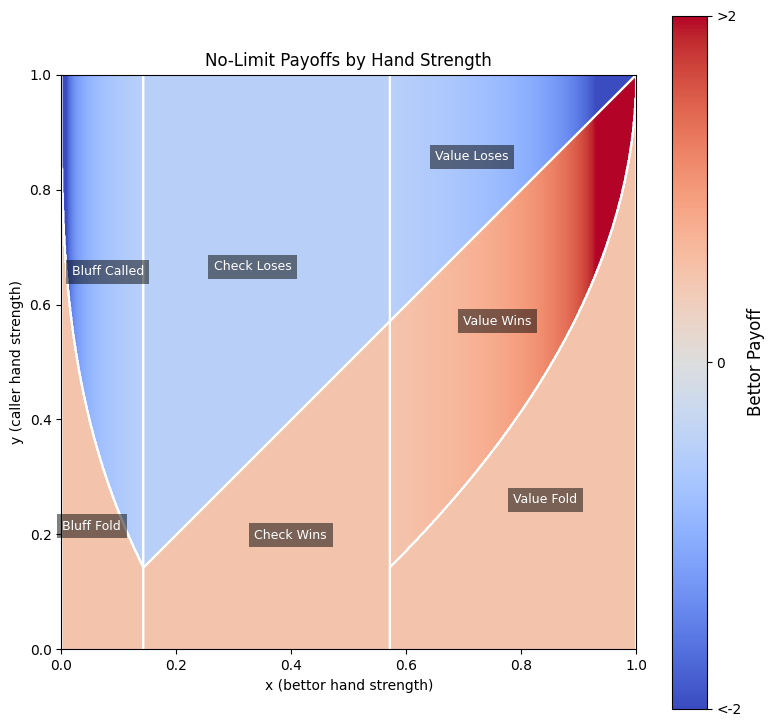

In [79]:
# NO LIMIT POKER

# ---- Parameters ----
grid_size = 1001
xs = np.linspace(0, 1, grid_size)
ys = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(xs, ys, indexing='ij')
color_cap = 2

# ---- Thresholds and inverse functions ----
bluff_threshold = 1 / 7
value_threshold = 4 / 7

def bluff_s(x):
    return np.where((x > 0) & (x < bluff_threshold), (1 / (7 * x)**(1/3)) - 1, np.nan)

def value_s(x):
    return np.where((x > value_threshold) & (x < 1), np.sqrt(3 / (7 * (1 - x))) - 1, np.nan)

def call_threshold_y(s):
    return 1 - 6 / (7 * (1 + s))

# ---- Payoff calculation for dynamic s ----
def payoff_NoLimit(x, y):
    if x < bluff_threshold:
        s = bluff_s(x)
        return np.where(np.isnan(s) | (s <= 0), np.nan, np.where(y > call_threshold_y(s), -s - 0.5, 0.5))
    elif x > value_threshold:
        s = value_s(x)
        return np.where(np.isnan(s) | (s <= 0), np.nan,
                        np.where(y > call_threshold_y(s),
                                 np.where(y < x, s + 0.5, -s - 0.5),
                                 0.5))
    else:
        return np.where(x > y, 0.5, -0.5)

# ---- Compute payoff grid ----
payoff_data = np.empty((grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        try:
            val = payoff_NoLimit(xs[i], ys[j])
            payoff_data[i, j] = val if np.isfinite(val) else np.nan
        except:
            payoff_data[i, j] = np.nan

payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

# ---- Classify outcomes ----
def classify_outcome(x, y):
    if x < bluff_threshold:
        s = bluff_s(x)
        if np.isnan(s) or s <= 0: return "Undefined"
        return "Bluff_Called" if y > call_threshold_y(s) else "Bluff_Fold"
    elif x > value_threshold:
        s = value_s(x)
        if np.isnan(s) or s <= 0: return "Undefined"
        if y > call_threshold_y(s):
            return "Value_Wins" if y < x else "Value_Loses"
        else:
            return "Value_Fold"
    else:
        return "Check_Wins" if x > y else "Check_Loses"

outcome_type = np.empty((grid_size, grid_size), dtype=object)
for i in range(grid_size):
    for j in range(grid_size):
        outcome_type[i, j] = classify_outcome(xs[i], ys[j])

region_labels = [
    "Bluff_Called", "Bluff_Fold",
    "Value_Wins", "Value_Loses", "Value_Fold",
    "Check_Wins", "Check_Loses"
]
label_to_index = {label: i for i, label in enumerate(region_labels)}
region_indices = np.vectorize(lambda l: label_to_index.get(l, -1))(outcome_type)

# ---- Plot heatmap with region contours and labels ----
fig, ax = plt.subplots(figsize=(8, 8))
c = ax.imshow(
    payoff_clipped.T,
    extent=[0, 1, 0, 1],
    origin='lower',
    cmap='coolwarm',
    norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
)
cbar = fig.colorbar(c, ax=ax, shrink=0.9)
cbar.set_label("Bettor Payoff", fontsize=12)
cbar.set_ticks([-color_cap, 0, color_cap])
cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

for label in region_labels:
    mask = outcome_type == label
    if np.any(mask):
        ax.contour(
            X, Y, mask.astype(float),
            levels=[0.5],
            colors='white',
            linewidths=1.5
        )
        region_center = np.argwhere(mask)
        if len(region_center) > 0:
            center_x, center_y = region_center.mean(axis=0)
            ax.text(
                xs[int(center_x)], ys[int(center_y)],
                label.replace("_", " "),
                color="white",
                fontsize=9,
                ha="center",
                va="center",
                bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
            )

ax.set_xlabel("x (bettor hand strength)")
ax.set_ylabel("y (caller hand strength)")
ax.set_title("No-Limit Payoffs by Hand Strength")
plt.tight_layout()
plt.savefig("no_limit_payoff_heatmap.png", dpi=300)
plt.show()


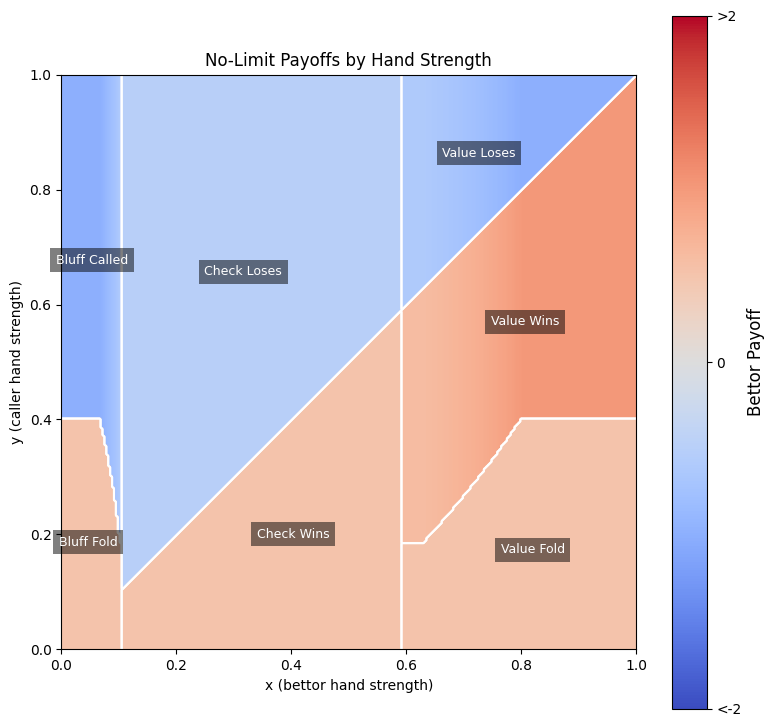

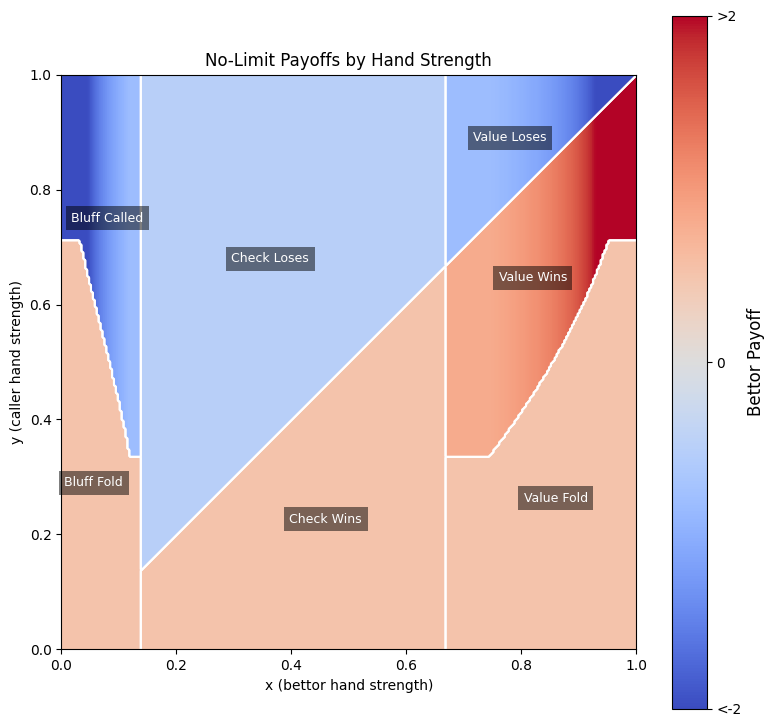

In [64]:
# L, U LIMIT POKER

# ---- Strategy functions ----
def compute_Ais(L, U):
    """
    Compute the A_i values based on the given L and U.
    """
    A0 = U**2 + 3 * U + 3
    A1 = 7 * U**3 + 21 * U**2 + 21 * U + 6
    A2 = 6 * U**3 + 18 * U**2 + 18 * U + 5
    A3 = 7 * U**3 + 21 * U**2 + 18 * U + 3
    A4 = 3 * A1 * L**2 + 3 * A1 * L + A1 + A2 * L**3
    A5 = 3 * A0 * L**2 * U + 3 * A0 * L * U + A0 * U - L**3
    return A0, A1, A2, A3, A4, A5


def compute_xis(L, U):
    """
    Compute the x_i values based on the given L, U, and the A_i values.
    """
    A0, A1, A2, A3, A4, A5 = compute_Ais(L, U)

    x0 = (3 * (L + 1)**3 * U) / A4
    x1 = (3 * A0 * L * U + A0 * U - L**3 - 3 * L**2) / A4
    x2 = A5 / A4
    x3 = (A2 * L**3 + 3 * A2 * L**2 + 3 * L * (5 * U**3 + 15 * U**2 + 15 * U + 4) +
          4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
    x4 = (3 * A1 * L**2 + A2 * L**3 + 3 * A2 * L + 4 * U**3 + 12 * U**2 + 12 * U + 3) / A4
    x5 = (3 * A3 * L**2 + 3 * A3 * L + A3 + L**3 * (6 * U**3 + 18 * U**2 + 15 * U + 2)) / A4
    b0 = -(L+1)**3 / A4
    return x0, x1, x2, x3, x4, x5, b0

def b_of_s(s, b0, x2):
    return b0 - ((1 + 3*s)*(x2 - 1)) / (6*(1 + s)**3)

def inverse_b(x, b0, x2, bracket=(1e-6, 100)):
    # Solve b(s) = x for s
    f = lambda s: b_of_s(s, b0, x2) - x
    sol = root_scalar(f, bracket=bracket, method='brentq')
    if sol.converged:
        return sol.root
    else:
        raise ValueError("Root finding did not converge")
    
def v_of_s(s, x2):
    # Compute v(s) based on the given s, b0, and x2
    return (x2 + 2*s**2 + 4*s + 1)/(2*(1 + s)**2)

def inverse_v(x, x2, bracket=(1e-6, 100)):
    # Solve v(s) = x for s
    f = lambda s: v_of_s(s, x2) - x
    sol = root_scalar(f, bracket=bracket, method='brentq')
    if sol.converged:
        return sol.root
    else:
        raise ValueError("Root finding did not converge")

def call_threshold_LU(s, x2):
    return (x2+s)/(1+s)

# ---- Classify outcomes and get payoff ----
def payoff_outcome_LU(x, y, L, U):
    x0, x1, x2, x3, x4, x5, b0 = compute_xis(L, U)
    if x < x2: # bluffs
        if x < x0:
            s = U
        elif x < x1:
            s = inverse_b(x, b0, x2)
        else:
            s = L
        if y > call_threshold_LU(s, x2):
            return "Bluff_Called", -s - 0.5
        else:
            return "Bluff_Fold", 0.5
    elif x < x3:
        if x > y:
            return "Check_Wins", 0.5
        else:
            return "Check_Loses", -0.5
    else: # value
        if x < x4:
            s = L
        elif x < x5:
            s = inverse_v(x, x2)
        else:
            s = U
        if y > call_threshold_LU(s, x2):
            if y < x:
                return "Value_Wins", s + 0.5
            else:
                return "Value_Loses", -s - 0.5
        else:
            return "Value_Fold", 0.5
    
def generate_payoff_plot_LU(L, U, grid_size=1001):
    # ---- Parameters ----
    xs = np.linspace(0, 1, grid_size)
    ys = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    color_cap = 2

    # ---- Compute payoff grid ----
    payoff_data = np.empty((grid_size, grid_size))
    outcome_type = np.empty((grid_size, grid_size), dtype=object)
    for i in range(grid_size):
        for j in range(grid_size):
            try:
                outcome, val = payoff_outcome_LU(xs[i], ys[j], L, U)
                payoff_data[i, j] = val if np.isfinite(val) else np.nan
                outcome_type[i, j] = outcome
            except:
                payoff_data[i, j] = np.nan

    payoff_clipped = np.clip(payoff_data, -color_cap, color_cap)

    regions = [
        "Bluff_Called", "Bluff_Fold",
        "Value_Wins", "Value_Loses", "Value_Fold",
        "Check_Wins", "Check_Loses"
    ]
    label_to_index = {label: i for i, label in enumerate(regions)}
    region_indices = np.vectorize(lambda l: label_to_index.get(l, -1))(outcome_type)

    # ---- Plot heatmap with region contours and labels ----
    fig, ax = plt.subplots(figsize=(8, 8))
    c = ax.imshow(
        payoff_clipped.T,
        extent=[0, 1, 0, 1],
        origin='lower',
        cmap='coolwarm',
        norm=TwoSlopeNorm(vmin=-color_cap, vcenter=0, vmax=color_cap)
    )
    cbar = fig.colorbar(c, ax=ax, shrink=0.9)
    cbar.set_label("Bettor Payoff", fontsize=12)
    cbar.set_ticks([-color_cap, 0, color_cap])
    cbar.set_ticklabels([f"<-{color_cap}", "0", f">{color_cap}"])

    for label in regions:
        mask = outcome_type == label
        if np.any(mask):
            ax.contour(
                X, Y, mask.astype(float),
                levels=[0.5],
                colors='white',
                linewidths=1.5
            )
            region_center = np.argwhere(mask)
            if len(region_center) > 0:
                center_x, center_y = region_center.mean(axis=0)
                ax.text(
                    xs[int(center_x)], ys[int(center_y)],
                    label.replace("_", " "),
                    color="white",
                    fontsize=9,
                    ha="center",
                    va="center",
                    bbox=dict(facecolor="black", alpha=0.5, edgecolor="none")
                )

    ax.set_xlabel("x (bettor hand strength)")
    ax.set_ylabel("y (caller hand strength)")
    ax.set_title("No-Limit Payoffs by Hand Strength")
    plt.tight_layout()
    plt.savefig("no_limit_payoff_heatmap.png", dpi=300)
    plt.show()


Ls = [0.1, 0.3]
Us = [0.5, 2]
for L, U in zip(Ls, Us):
    generate_payoff_plot_LU(L, U, 301)

# payoff_outcome_LU(0.5, 0.5, 0.5, 1.0)

In [76]:
# LU LIMIT POKER EXPECTED PAYOFF OVER L, U GRID

def expected_payoff(payoff_function, grid_size=1001):
    # numerically integrate the payoff(x, y) function over the grid [0,1] x [0,1]
    xs = np.linspace(0, 1, grid_size)
    ys = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(xs, ys, indexing='ij')
    payoff_data = np.empty((grid_size, grid_size))
    for i in range(grid_size):
        for j in range(grid_size):
            try:
                val = payoff_function(xs[i], ys[j])
                payoff_data[i, j] = val if np.isfinite(val) else np.nan
            except:
                payoff_data[i, j] = np.nan
    average_payoff = np.nanmean(payoff_data)
    return average_payoff

# print(expected_payoff(lambda x, y: payoff_outcome_LU(x, y, 1, 1)))
# print(expected_payoff(payoff_NoLimit))
print(expected_payoff(lambda x, y: payoff(1, x, y), 11))

    


nan


/var/folders/b1/z91xjqp97qb1ts5z67d5h7f00000gn/T/ipykernel_7388/1394443586.py:16: RuntimeWarning: Mean of empty slice
  average_payoff = np.nanmean(payoff_data)
